In [15]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set(style='ticks', context='paper', rc={'font.sans-serif':'Arial', 'pdf.fonttype': 42})

%matplotlib inline

import flotilla


flotilla_dir = '/projects/ps-yeolab/obotvinnik/flotilla_projects'

study = flotilla.embark('singlecell_pnm_figure1_supplementary_post_splicing_filtering', flotilla_dir=flotilla_dir)

not_outliers = study.splicing.singles.index.difference(study.splicing.outliers.index)
folder = 'pdfs' #'/home/obotvinnik/Dropbox/figures2/singlecell_pnm/figure2_modalities/bayesian'
! mkdir $folder

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2016-04-14 11:12:40	Reading datapackage from /projects/ps-yeolab/obotvinnik/flotilla_projects/singlecell_pnm_figure1_supplementary_post_splicing_filtering/datapackage.json
2016-04-14 11:12:40	Parsing datapackage to create a Study object
2016-04-14 11:13:25	Initializing Study
2016-04-14 11:13:25	Initializing Predictor configuration manager for Study
2016-04-14 11:13:25	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2016-04-14 11:13:25	Added ExtraTreesClassifier to default predictors
2016-04-14 11:13:25	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2016-04-14 11:13:25	Added ExtraTreesRegressor to default predictors
2016-04-14 11:13:25	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2016-04-14 11:13:25	Added GradientBoostingClassifier

In [16]:
splicing_singles_no_outliers = study.splicing.singles.ix[not_outliers]
print splicing_singles_no_outliers.shape

(183, 11558)


## Estimate modalities

### Initialize the modality estimator

In [17]:
import anchor

bayesian = anchor.BayesianModalities()
# binned = anchor.BinnedModalities()
# monte_carlo = anchor.MonteCarloModalities()

In [18]:
# fig = estimator.violinplot(n=1e6)
# for ax in fig.axes:
#     ax.set(yticks=[0, 0.5, 1], xlabel='')
# fig.tight_layout()
# sns.despine()
# fig.savefig('{}/modality_estimator_parameterized_family.pdf'.format(folder))

## Calculate/Estimate modalities only on single cells, with no outliers

And at least 20 cells per splicing event, per celltype/phenotype

In [19]:
print splicing_singles_no_outliers.shape
splicing_singles_no_outliers = splicing_singles_no_outliers.groupby(
    study.sample_id_to_phenotype).apply(lambda x: x.dropna(thresh=20, axis=1))
print splicing_singles_no_outliers.shape

(183, 11558)
(183, 8028)


In [20]:
pkm_events = study.splicing.maybe_renamed_to_feature_id('PKM')

In [21]:
%time modality_assignments = splicing_singles_no_outliers.groupby(study.sample_id_to_phenotype).apply(bayesian.fit_predict)

CPU times: user 8min 48s, sys: 117 ms, total: 8min 48s
Wall time: 8min 48s


In [22]:
modality_assignments

,exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,exon:chr10:101480744-101480825:-@exon:chr10:101478103-101478257:-@exon:chr10:101476105-101476218:-,exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514391:+,exon:chr10:101997779-101997988:-@exon:chr10:101996607-101996726:-@exon:chr10:101995424-101995521:-,exon:chr10:102003455-102003534:-@exon:chr10:101997779-101997988:-@exon:chr10:101996607-101996726:-,exon:chr10:102013178-102013296:-@exon:chr10:102010005-102010089:-@exon:chr10:102006552-102006692:-,exon:chr10:102019975-102020076:-@exon:chr10:102016019-102016233:-@exon:chr10:102013178-102013296:-,exon:chr10:102020723-102020801:-@exon:chr10:102019975-102020076:-@exon:chr10:102016019-102016233:-,exon:chr10:102114184-102114389:+@exon:chr10:102116289-102116521:+@exon:chr10:102120491-102124591:+,exon:chr10:102286732-102286831:-@exon:chr10:102286156-102286311:-@exon:chr10:102283500-102283686:-,...,exon:chrY:15024875-15024974:+@exon:chrY:15025630-15025765:+@exon:chrY:15026476-15026561:+,exon:chrY:15026476-15026561:+@exon:chrY:15026796-15026894:+@exon:chrY:15026979-15027139:+,exon:chrY:15027542-15027686:+@exon:chrY:15027795-15027939:+@exon:chrY:15028173-15028354:+,exon:chrY:15028429-15028546:+@exon:chrY:15028819-15028972:+@exon:chrY:15029315-15029454:+,exon:chrY:22744476-22744579:+@exon:chrY:22746360-22746410:+@exon:chrY:22749910-22749991:+,exon:chrY:2709527-2709668:+@exon:chrY:2710206-2710283:+@exon:chrY:2712118-2712298:+,exon:chrY:2710206-2710283:+@exon:chrY:2712118-2712298:+@exon:chrY:2713687-2713784:+,exon:chrY:2712118-2712298:+@exon:chrY:2713687-2713784:+@exon:chrY:2722641-2722812:+,exon:chrY:2713687-2713784:+@exon:chrY:2722641-2722812:+@exon:chrY:2733129-2733286:+,exon:chrY:2722641-2722812:+@exon:chrY:2733129-2733286:+@exon:chrY:2734834-2734903:+
phenotype,,,,,,,,,,,,,,,,,,,,,
MN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,included,included,...,NaN,NaN,NaN,NaN,NaN,included,included,included,included,included
NPC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,included,included,...,NaN,NaN,NaN,NaN,included,included,included,included,included,included
iPSC,included,included,bimodal,included,included,bimodal,bimodal,bimodal,included,included,...,included,included,included,included,included,included,included,included,included,included


In [23]:
modalities_tidy = modality_assignments.stack().reset_index()
modalities_tidy = modalities_tidy.rename(columns={'level_1': 'event_id', 0: "modality",})
modalities_tidy.head()

,phenotype,event_id,modality
0,MN,exon:chr10:102114184-102114389:+@exon:chr10:10...,included
1,MN,exon:chr10:102286732-102286831:-@exon:chr10:10...,included
2,MN,exon:chr10:103360960-103361093:+@exon:chr10:10...,bimodal
3,MN,exon:chr10:103563492-103563776:-@exon:chr10:10...,bimodal
4,MN,exon:chr10:103567487-103567658:-@exon:chr10:10...,included


In [24]:
modalities_tidy.loc[modalities_tidy.event_id.isin(pkm_events)]

,phenotype,event_id,modality
649,MN,exon:chr15:72499069-72499221:-@exon:chr15:7249...,included
650,MN,exon:chr15:72499069-72499221:-@exon:chr15:7249...,bimodal
651,MN,exon:chr15:72523457-72523547:-@exon:chr15:7251...,excluded
3675,NPC,exon:chr15:72499069-72499221:-@exon:chr15:7249...,included
3676,NPC,exon:chr15:72499069-72499221:-@exon:chr15:7249...,included
3677,NPC,exon:chr15:72499069-72499221:-@exon:chr15:7249...,excluded
3678,NPC,exon:chr15:72523457-72523547:-@exon:chr15:7251...,excluded
9179,iPSC,exon:chr15:72499069-72499221:-@exon:chr15:7249...,included
9180,iPSC,exon:chr15:72499069-72499221:-@exon:chr15:7249...,excluded
9181,iPSC,exon:chr15:72523457-72523547:-@exon:chr15:7251...,excluded


In [25]:
modalities_counts = modalities_tidy.groupby(['phenotype', 'modality']).count().reset_index()
modalities_counts = modalities_counts.rename(columns={'event_id': '# AS events'})
modalities_counts.head()

,phenotype,modality,# AS events
0,MN,bimodal,356
1,MN,excluded,541
2,MN,included,1553
3,MN,uncategorized,1
4,NPC,bimodal,751


In [26]:
from anchor import MODALITY_ORDER, MODALITY_PALETTE, MODALITY_TO_COLOR

In [27]:
modalities_counts_2d = modalities_counts.pivot(index='phenotype', columns='modality', values='# AS events')
modalities_counts_2d = modalities_counts_2d.reindex(columns=MODALITY_ORDER, index=study.phenotype_order)
modalities_counts_2d = modalities_counts_2d.T
modalities_counts_2d

phenotype,iPSC,NPC,MN
modality,,,
excluded,1558,1049,541
bimodal,1348,751,356
included,4632,3029,1553
middle,1,NaN,NaN
uncategorized,31,3,1


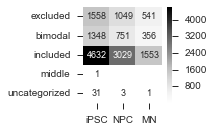

In [35]:
fig, ax= plt.subplots(figsize=(3, 2))
mask = modalities_counts_2d.isnull()
sns.heatmap(modalities_counts_2d, annot=True, mask=mask, fmt='g', annot_kws=dict(size=9), cmap='Greys')
ax.set(xlabel='', ylabel='')
fig.tight_layout()
fig.savefig('{}/modalities_counts_heatmap.pdf'.format(folder))

In [29]:
modalities_counts['percentage'] = 100*modalities_counts.groupby('phenotype')['# AS events'].apply(lambda x: x/x.sum())
modalities_counts

,phenotype,modality,# AS events,percentage
0,MN,bimodal,356,14.524684
1,MN,excluded,541,22.072623
2,MN,included,1553,63.361893
3,MN,uncategorized,1,0.040800
4,NPC,bimodal,751,15.542219
5,NPC,excluded,1049,21.709437
6,NPC,included,3029,62.686258
7,NPC,uncategorized,3,0.062086
8,iPSC,bimodal,1348,17.807133
9,iPSC,excluded,1558,20.581242


/home/obotvinnik/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:2848: UserWarning: The `x_order` parameter has been renamed `order`
  UserWarning)


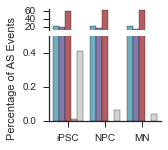

In [30]:
sns.set(style='ticks')
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(2, 2), gridspec_kw=dict(hspace=0.1, height_ratios=[0.2, 0.8]))

ax = axes[0]
sns.barplot(x='phenotype', hue='modality', y='percentage', data=modalities_counts, ax=ax,
            hue_order=MODALITY_ORDER, palette=MODALITY_PALETTE, x_order=study.phenotype_order)
ax.legend_.set_visible(False)
ax.locator_params('y', nbins=4)
sns.despine(ax=ax, bottom=True)
ax.tick_params(axis='x', bottom='off')
ax.set(xticks=[], xlabel='', ylim=(10, 65), ylabel='') #yticks=[10, 50, ])

ax = axes[1]
sns.barplot(x='phenotype', hue='modality', y='percentage', data=modalities_counts, ax=ax,
           hue_order=MODALITY_ORDER, palette=MODALITY_PALETTE, x_order=study.phenotype_order)
ax.set(ylim=(0, 0.5), ylabel='Percentage of AS Events', 
       xlabel='')
ax.legend_.set_visible(False)
ax.locator_params('y', nbins=4)
sns.despine(ax=ax)
# fig.tight_layout()
fig.savefig('{}/modalities_barplot.pdf'.format(folder))

In [31]:
study.supplemental.modalities_tidy = modalities_tidy

In [32]:
modalities_tidy.groupby(['phenotype', 'modality']).size()

phenotype  modality     
MN         bimodal           356
           excluded          541
           included         1553
           uncategorized       1
NPC        bimodal           751
           excluded         1049
           included         3029
           uncategorized       3
iPSC       bimodal          1348
           excluded         1558
           included         4632
           middle              1
           uncategorized      31
dtype: int64

In [33]:
flotilla_dir = '/projects/ps-yeolab/obotvinnik/flotilla_projects'
study.save('singlecell_pnm_figure2_modalities_bayesian', flotilla_dir=flotilla_dir)

Wrote datapackage to /projects/ps-yeolab/obotvinnik/flotilla_projects/singlecell_pnm_figure2_modalities_bayesian/datapackage.json


In [34]:
event = 'exon:chr10:1043148-1043248:+@exon:chr10:1044943-1045035:+@exon:chr10:1046617-1046808:+'

event in study.splicing.data

False